In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import os
import sys
import time
import copy
import pickle
from tqdm.auto import trange

import numpy as np
import numpy.random as npr
from scipy.stats import multivariate_normal as mvn
from scipy.special import logsumexp
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as manimation
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Rectangle
from matplotlib.cm import jet
from matplotlib.gridspec import GridSpec

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from ssm.models import HMM
from ssm.util import rle
from ssm.primitives import hmm_sample, lds_sample
from ssm.observations import GaussianObservations
from ssm.init_state_distns import InitialStateDistribution
from ssm.preprocessing import trend_filter, pca_with_imputation

In [9]:
sys.path.insert(0, '..')
import ssm_harness as harness
from ssm_harness import cached

In [10]:
npr.seed(0)
sns.set_style("white")
sns.set_context("talk")

# Load the data

In [11]:
with open("latents-nocrop-05-fold.pkl", "rb") as f:
    data = pickle.load(f)
    
latents = data['latents'].astype(np.float64)
T_total, D = latents.shape

# Extract the segments of training data
def extract_segments(latents, indices):
    values, durations = rle(indices)
    offsets = np.concatenate(([0], np.cumsum(durations)[:-1]))
    segments = [latents[offset:offset+duration] 
                for value, offset, duration in zip(values, offsets, durations)
                if value == True]
    new_indices = [np.arange(offset,offset+duration)
                for value, offset, duration in zip(values, offsets, durations)
                if value == True]
    return segments, new_indices

training_data, train_indices = extract_segments(latents, data['indxs']['train'])
validation_data, validation_indices = extract_segments(latents, data['indxs']['validation'])
test_data, test_indices = extract_segments(latents, data['indxs']['test'])
all_training_data = np.concatenate(training_data, axis=0)

T_train = sum([len(x) for x in training_data])
T_val = sum([len(x) for x in validation_data])
T_test = sum([len(x) for x in test_data])

In [12]:
# Load the neural data
neural_data = np.load("np_spikes.npy").astype(float)
num_neurons = neural_data.shape[1]

In [13]:
# Load the VAE
import tensorflow as tf
from nntools.models import Model

vae_file = '/Volumes/paninski-locker/data/steinmetz/behavior/dual-phase/full_08-dim-ae/05-fold-01/model_file.pkl'
vae = Model.load_model(vae_file)
vae._check_graph(None, None)

# Load the VAE weights
sess = tf.Session(graph=vae.graph, config=vae.sess_config)
checkpoint_file = '/Volumes/paninski-locker/data/steinmetz/behavior/dual-phase/full_08-dim-ae/05-fold-01/checkpoints/epoch_00999.ckpt'
vae.restore_model(sess, checkpoint_file=checkpoint_file)



model loaded from /Volumes/paninski-locker/data/steinmetz/behavior/dual-phase/full_08-dim-ae/05-fold-01/model_file.pkl
trainer: adam
data pipeline: feed_dict
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Volumes/paninski-locker/data/steinmetz/behavior/dual-phase/full_08-dim-ae/05-fold-01/checkpoints/epoch_00999.ckpt


In [14]:
def decode(trajectory):
    """
    Decode a trajectory of continuous latent states
    """
    # restore model weights from checkpoint file
    # vae.restore_model(sess, checkpoint_file=checkpoint_file)

    # populate feed_dict with latent data
    feed_dict = {vae.network.input_phs[0]: trajectory}

    # populate feed_dict with dropout rates of 1.0 (no dropout)
    for key, value in vae.network.feed_dict.items():
        feed_dict[key] = value

    # push images through network to get reconstructions
    simulated_recon = sess.run(vae.network.layer_outputs[-1], feed_dict=feed_dict)
        
    return simulated_recon


# Preprocess the neural data with smoothing and PCA

In [15]:
_preprocess_neural_data = cached(".", "preprocessed_neural_data")(harness.preprocess_neural_data)
normalized_rates, lowd_neural_data, pca = _preprocess_neural_data(neural_data, fs=25, window=0.1)

Text(0.5, 0, 'PC')

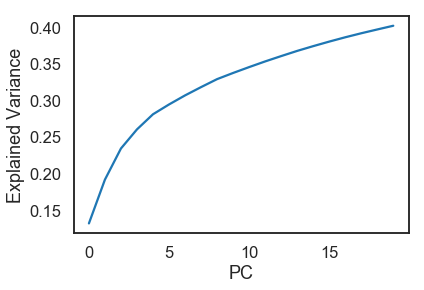

In [16]:
# Do some dimensionality reduction on the neural data
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel("Explained Variance")
plt.xlabel("PC")

In [17]:
# Choose the number of PCs to use
M = 8
training_inputs, _ = extract_segments(lowd_neural_data[:, :M], data['indxs']['train'])
validation_inputs, _ = extract_segments(lowd_neural_data[:, :M], data['indxs']['validation'])
test_inputs, _ = extract_segments(lowd_neural_data[:, :M], data['indxs']['test'])

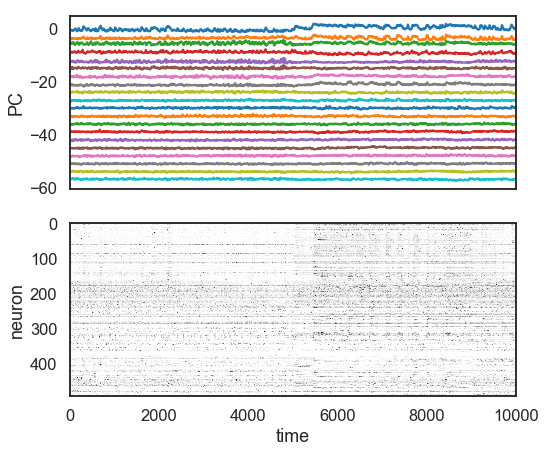

In [18]:
fig = harness.plot_neural_activity(lowd_neural_data, normalized_rates)
fig.savefig("neural_data.png", dpi=300)

# Fit ARHMM's to the behavioral data

In [19]:
# Fit a sticky tARHMM

num_discrete_states = np.arange(6, 7)

std_models = dict(
    
    arhmm=dict(transitions="standard", 
               observations="ar"),
    
)

input_models = dict(
    
    input_arhmm_zonly=dict(transitions="inputdriven", 
                           transition_kwargs=dict(l2_penalty=0.0), 
                           observations="no_input_ar"),
    
    input_arhmm=dict(transitions="inputdriven", 
                     transition_kwargs=dict(l2_penalty=0.0), 
                     observations="ar", 
                     observation_kwargs=dict(l2_penalty_V=0.0)),
    
#     tarhmm=dict(transitions="standard", observations="robust_ar"),
#     hmm=dict(transitions="standard", observations="gaussian"),
#     input_hmm=dict(transitions="inputdriven", transition_kwargs=dict(l2_penalty=0.0), observations="gaussian"),
#     input_tarhmm=dict(transitions="inputdriven", transition_kwargs=dict(l2_penalty=0.0), 
#                       observations="robust_ar", observation_kwargs=dict(l2_penalty_V=0.0)),
#     sticky_arhmm=dict(transitions="sticky", transition_kwargs=dict(kappa=100), observations="ar"),
#     sticky_tarhmm=dict(transitions="sticky", transition_kwargs=dict(kappa=100), observations="robust_ar"),
#     recurrent_arhmm=dict(transitions="recurrent", observations="ar"),
)

all_results = dict()

for model_name, kwargs in std_models.items():
    model_results = dict()
    for K in num_discrete_states:
        print("Fitting", model_name, "with", K, "states.")
        file_name = "{}_K{}.pkl".format(model_name, K)
        _fit = cached(".", file_name)(harness.fit_model)
        model_results[K] = _fit(K, D, 0, kwargs, 
                                training_data, validation_data, test_data)
        
    all_results[model_name] = model_results
    
for model_name, kwargs in input_models.items():
    model_results = dict()
    for K in num_discrete_states:
        print("Fitting", model_name, "with", K, "states.")
        file_name = "{}_K{}.pkl".format(model_name, K)
        _fit = cached(".", file_name)(harness.fit_model)
        model_results[K] = _fit(K, D, M, kwargs, 
                                training_data, validation_data, test_data, 
                                training_inputs, validation_inputs, test_inputs)
        
    all_results[model_name] = model_results

Fitting arhmm with 6 states.
Fitting input_arhmm_zonly with 6 states.
Fitting input_arhmm with 6 states.


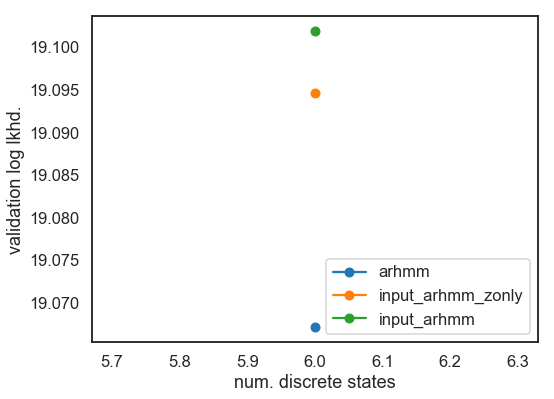

In [20]:
line_styles = dict(
    arhmm='-',
    input_arhmm='-',
    input_arhmm_zonly='-',
)

fig = harness.plot_validation_likelihoods(all_results, line_styles=line_styles, T_val=T_val)
fig.savefig("validation_likelihoods.png", dpi=300)

In [21]:
# Select the number of discrete states with the cross validated log likelihood
best_results = dict()
for model_name, model_results in all_results.items():
    val_lls = np.array([model_results[K]['val_ll'] for K in num_discrete_states])
    best_num_states = num_discrete_states[np.argmax(val_lls)]
    best_results[model_name] = model_results[best_num_states]

# Sample from the ARHMMs conditioned on neural data

In [22]:
test_idx = 0
T_smpl = test_inputs[test_idx].shape[0]

for model_name, model_results in best_results.items():
    print("Sampling ", model_name)
    model = model_results["model"]
    inputs = test_inputs[test_idx] if model.M > 0 else np.zeros((T_smpl, 0))
    
    _sample = cached(".", "{}_test{}_smpls".format(model_name, test_idx))(harness.sample_arhmm)
    model_results["z_smpls"], model_results["x_smpls"] = _sample(model, inputs)

Sampling  arhmm
Sampling  input_arhmm_zonly
Sampling  input_arhmm


# Make some plots

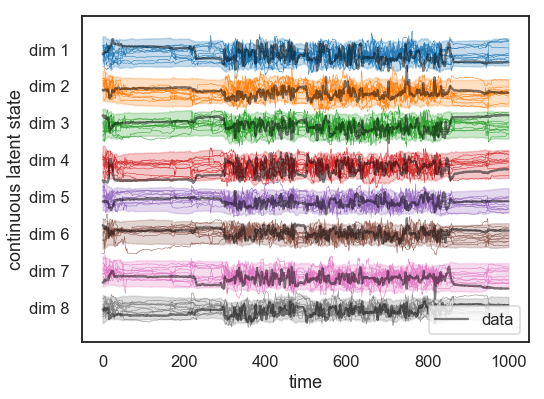

In [23]:
fig = harness.plot_sampled_latents(test_data[test_idx], best_results["input_arhmm"]["x_smpls"])
fig.savefig("./input_arhmm_xsmpls.png", dpi=300)

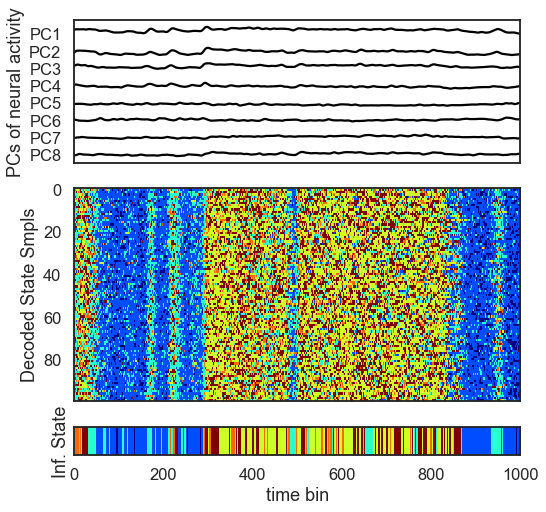

In [24]:
z_inf = best_results["input_arhmm"]["model"].most_likely_states(test_data[test_idx], 
                                                                input=test_inputs[test_idx])

fig = harness.plot_neural_and_discrete_samples(
    test_inputs[test_idx], 
    best_results["input_arhmm"]["z_smpls"],
    z_inf)

fig.savefig("./input_arhmm_zsmpls.png", dpi=300)

# Decode the samples with the VAE

In [25]:
print("Decoding the real data")
decoded_latents = decode(test_data[test_idx])

Decoding the real data


In [26]:
print("Decoding ARHMM samples")
decoded_samples = [decode(best_results["input_arhmm"]["x_smpls"][i]) for i in trange(4)]

Decoding ARHMM samples


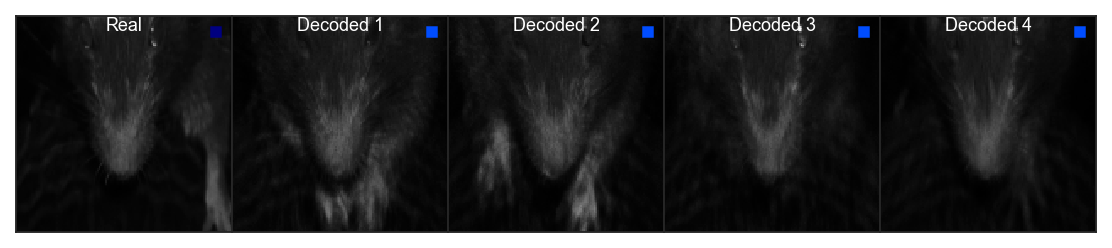

In [28]:
harness.make_hollywood_movie(best_results["input_arhmm"]["model"].K,
                             decoded_latents, 
                             z_inf, 
                             decoded_samples, 
                             best_results["input_arhmm"]["z_smpls"][:4])